<div style='background-image: url("title01.png") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 200px'>
<div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Computational Seismology</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Spectral Element Method - 1D Elastic Wave Equation, Heterogeneous case</div>
        </div>
    </div>
</div>

## Basic Equations

The numerical description of 1D-elastic waves propagating in a heterogeneous media is a natural extension of the homogeneous case. From an algorithmic point of view, now we allow both mass, and stiffness matrices to be initialized separately for each element. In contrast with the homogeneous case, elastic parameters $\lambda$ and $\mu$ may vary at each collocation point. 

From a theoretical point of view, we basically follow the same strategy developed in the homogeneous case. The numerical solution for the 1D elastic wave equation

\begin{equation}
\rho(x) \partial_t^2 u(x,t) = \partial_x (\mu(x) \partial_x u(x,t)) + f(x,t),
\end{equation}

using the spectral element method is done after a series of steps summarized as follow:

1) The wave equation is written into its weak form

2) Assume stress-free boundary condition after integration by parts 

3) Approximate the wave field as a linear combination of some basis

\begin{equation}
u(x,t) \ \approx \ \overline{u}(x,t) \ = \ \sum_{i=1}^{n} u_i(t) \ \varphi_i(x)
\end{equation}

4) Use the same basis functions in $u(x, t)$ as test functions in the weak form, the so call Galerkin principle.

6) The continuous weak form is written as a system of linear equations by considering the approximated displacement field.

\begin{equation}
\mathbf{M}^T\partial_t^2 \mathbf{u} + \mathbf{K}^T\mathbf{u} = \mathbf{f}
\end{equation}

7) Time extrapolation with centered finite differences scheme

\begin{equation}
\mathbf{u}(t + dt) = dt^2 (\mathbf{M}^T)^{-1}[\mathbf{f} - \mathbf{K}^T\mathbf{u}] + 2\mathbf{u} - \mathbf{u}(t-dt).
\end{equation}

where $\mathbf{M}$ is known as the mass matrix, and $\mathbf{K}$ the stiffness matrix.

The above solution is exactly the same presented for the classic finite-element method. Now we introduce appropriated basis functions and integration scheme to efficiently solve the system of matrices.

#### Interpolation with Lagrange Polynomials
At the elemental level (see section 7.4), we introduce as interpolating functions the Lagrange polynomials and use $\xi$ as the space variable representing our elemental domain:

\begin{equation}
\varphi_i \ \rightarrow \ \ell_i^{(N)} (\xi) \ := \ \prod_{j \neq i}^{N+1} \frac{\xi - \xi_j}{\xi_i-\xi_j}, \qquad   i,j = 1, 2, \dotsc , N + 1  
\end{equation}

#### Numerical Integration
The integral of a continuous function $f(x)$ can be calculated after replacing $f(x)$ by a polynomial approximation that can be integrated analytically. As interpolating functions we use again the Lagrange polynomials and
obtain Gauss-Lobatto-Legendre quadrature. Here, the GLL points are used to perform the integral. 

\begin{equation}
\int_{-1}^1 f(x) \ dx \approx \int _{-1}^1 P_N(x) dx = \sum_{i=1}^{N+1}
 w_i f(x_i) 
\end{equation}


In [1]:
# Import all necessary libraries, this is a configuration step for the exercise.
# Please run it before the simulation code!
import numpy as np
import matplotlib
# Show Plot in The Notebook
matplotlib.use("nbagg")
import matplotlib.pyplot as plt

from gll import gll
from lagrange1st import lagrange1st 
from ricker import ricker


### 1. Initialization of setup

In [2]:
# Initialization of setup
# ---------------------------------------------------------------
nt    = 7500         # number of time steps
xmax  = 8000.         # Length of domain [m]
N     = 3             # Order of Lagrange polynomials
ne    = 150           # Number of elements
Tdom  = .4            # Dominant period of Ricker source wavelet
iplot = 30            # Plotting each iplot snapshot
vs    = 2500.         # S velocity [m/s]
rho   = 2000          # Density [kg/m^3]

# variables for elemental matrices
Me = np.zeros(N+1, dtype =  float)
Ke = np.zeros((N+1, N+1), dtype =  float)
# ----------------------------------------------------------------

# Initialization of GLL points integration weights
[xi, w] = gll(N)    # xi, N+1 coordinates [-1 1] of GLL points
                    # w Integration weights at GLL locations
# Space domain
le = xmax/ne        # Length of elements
# Vector with GLL points  
k = 0
xg = np.zeros((N*ne)+1) 
xg[k] = 0
for i in range(1,ne+1):
    for j in range(0,N):
        k = k+1
        xg[k] = (i-1)*le + .5*(xi[j+1]+1)*le

# ---------------------------------------------------------------
dxmin = min(np.diff(xg))  
eps = 0.1           # Courant value
dt = eps*dxmin/vs   # Global time step

# Mapping - Jacobian
J = le/2 
Ji = 1/J    # Inverse Jacobian

# 1st derivative of Lagrange polynomials
l1d = lagrange1st(N)   # Array with GLL as columns for each N+1 polynomial

### 2. Low velocity zone
The introduction of an specific velocity model is done after allowing space-dependent elastic parameters. i.e. 

\begin{equation}
\mu(x) = \rho(x) v_s(x)
\end{equation}

#### Exercise 1 
Introduce a low-velocity zone (-40%) at the center of the model spanning 50 elements. Then, visualize your model. Additionally, you can try different velocity and density models by defining new python methods.

In [3]:
# Elastic parameters, Low velocity zone(-40%)
# ----------------------------------------------------------------
el_span = 25                     # Number of elements spanning the Low velocity zone
percent = 0.4                    # percentage of velocity reduction 
a = el_span*N + 1                # width of the fault zone in grid points
b = int(np.floor((N*ne +1)/2))   # half of the space domain. 

vs  = vs * np.ones((N*ne +1))
rho = rho * np.ones((N*ne +1))

vs[b-int(a/2):b+int(a/2)] = max(vs) * percent
mu  = rho * vs**2                  # Shear modulus mu

<IPython.core.display.Javascript object>


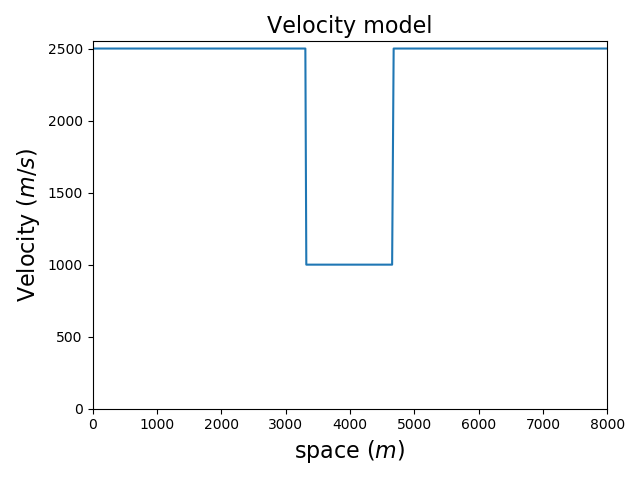

In [4]:
# To avoid testing (with py.test nbval ...) the plotting section 
# NBVAL_IGNORE_OUTPUT
# ----------------------------------------------------------------
# Plot velocity model, Low velocity zone(-30%)
# ----------------------------------------------------------------
plt.plot(xg, vs, lw = 1.5)
plt.title('Velocity model',fontsize=16)
plt.ylabel('Velocity $(m/s)$',fontsize=16)
plt.xlabel('space $(m)$',fontsize=16)
plt.xlim((0,xmax))
plt.ylim((0,max(vs)+50))
plt.tight_layout()
plt.show()

### 3. The Mass Matrix
Now we initialize the mass and stiffness matrices. In general, the mass matrix at the elemental level is given

\begin{equation}
M_{ji}^e \ = \ w_j  \ \rho (\xi)  \ \frac{\mathrm{d}x}{\mathrm{d}\xi} \delta_{ij} \vert_ {\xi = \xi_j}
\end{equation}

#### Exercise 2 
Implements the mass matrix at each element using the integration weights at GLL locations $w$, the Jacobian $J$, and density $\rho$. Then, perform the global assembly of the mass matrix, compute its inverse, and display the inverse mass matrix to visually inspect how it looks like.

<IPython.core.display.Javascript object>


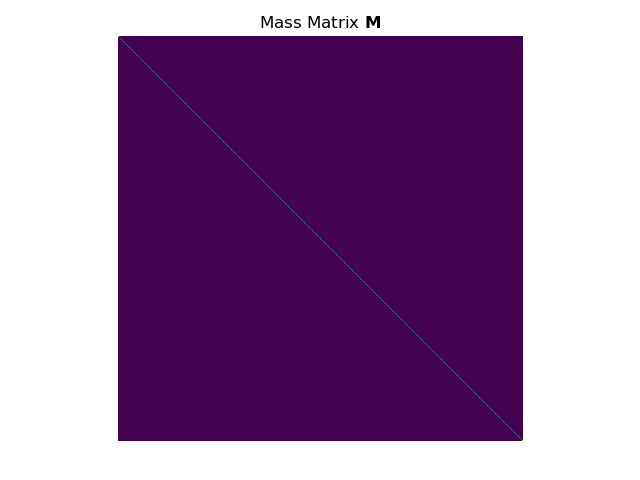

In [5]:
# Global Mass matrix
# --------------------------------------------------------------- 
k = -1
m = -1
ng = (ne-1)*N + N + 1
M = np.zeros(2*ng) 
for i in range(1, ne+1): 
    # ------------------------------------
    # Elemental Mass matrix
    # ------------------------------------
    for l in range(0, N+1):
        m += 1
        Me[l] = rho[m] * w[l] * J    #stored as a vector since it's diagonal
    m -= 1 
    # ------------------------------------
    for j in range(0, N+1): 
        k = k + 1
        if i>1:
            if j==0:
                k = k - 1
        M[k] = M[k] + Me[j]

# Inverse matrix of M 
# --------------------------------------------------------------- 
Minv = np.identity(ng)
for i in range(0,ng):
    Minv[i,i] = 1./M[i]
    

# To avoid testing (with py.test nbval ...) the plotting section 
# NBVAL_IGNORE_OUTPUT
# --------------------------------------------------------------
# Display inverse mass matrix inv(M)
# --------------------------------------------------------------
plt.figure()
plt.imshow(Minv)
plt.title('Mass Matrix $\mathbf{M}$')
plt.axis("off")
plt.tight_layout()
plt.show()     

### 4. The Stiffness matrix
On the other hand, the general form of the stiffness matrix at the elemental level is

\begin{equation}
K_{ji}^e \ = \ \sum_{k = 1}^{N+1} w_k \mu (\xi) \partial_\xi \ell_j (\xi) \partial_\xi \ell_i (\xi) \left(\frac{\mathrm{d}\xi}{\mathrm{d}x} \right)^2 \frac{\mathrm{d}x}{\mathrm{d}\xi} \vert_{\xi = \xi_k}
\end{equation} 

#### Exercise 3 
Implements the stiffness matrix at each element using the integration weights at GLL locations $w$, the Jacobian $J$, and shear stress $\mu$. Then, perform the global assembly of the mass matrix and display the matrix to visually inspect how it looks like.

<IPython.core.display.Javascript object>


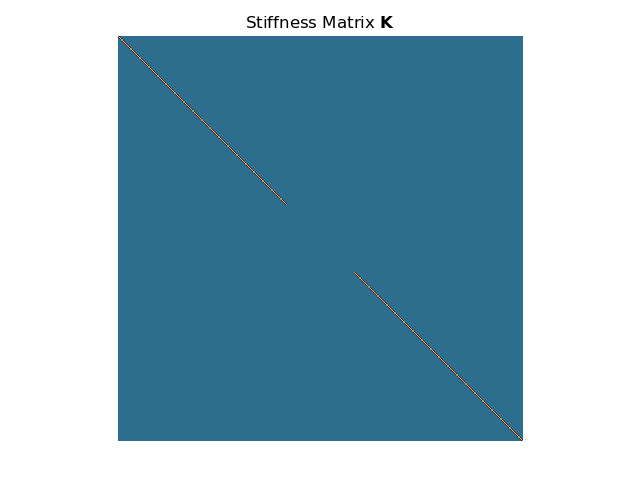

In [6]:
# Global Stiffness Matrix
# --------------------------------------------------------------- 
K = np.zeros([ng, ng])
xe = 0 

for e in range(1, ne + 1):
    i0 = (e - 1)*N + 1
    j0 = i0
    # ------------------------------------
    # Elemental Stiffness Matrix
    # ------------------------------------
    for i in range(-1, N):
        for j in range(-1, N):
            sum = 0
            for k in range(-1, N):                
                sum = sum + mu[k+1+xe] * w[k+1] * Ji**2 * J * l1d[i+1,k+1] * l1d[j+1,k+1]
            Ke[i+1, j+1] = sum    
    xe += N

    for i in range(-1,N):
        for j in range(-1, N):
            K[i0+i, j0+j] += Ke[i+1, j+1]

# To avoid testing (with py.test nbval ...) the plotting section 
# NBVAL_IGNORE_OUTPUT
# --------------------------------------------------------------
# Display stiffness matrix K
# --------------------------------------------------------------
plt.figure()
plt.imshow(K)
plt.title('Stiffness Matrix $\mathbf{K}$')
plt.axis("off")

plt.tight_layout()
plt.show()

### 5. Finite element solution 

Finally we implement the spectral element solution using the computed mass $M$ and stiffness $K$ matrices together with a finite differences extrapolation scheme

\begin{equation}
\mathbf{u}(t + dt) = dt^2 (\mathbf{M}^T)^{-1}[\mathbf{f} - \mathbf{K}^T\mathbf{u}] + 2\mathbf{u} - \mathbf{u}(t-dt).
\end{equation}

<IPython.core.display.Javascript object>


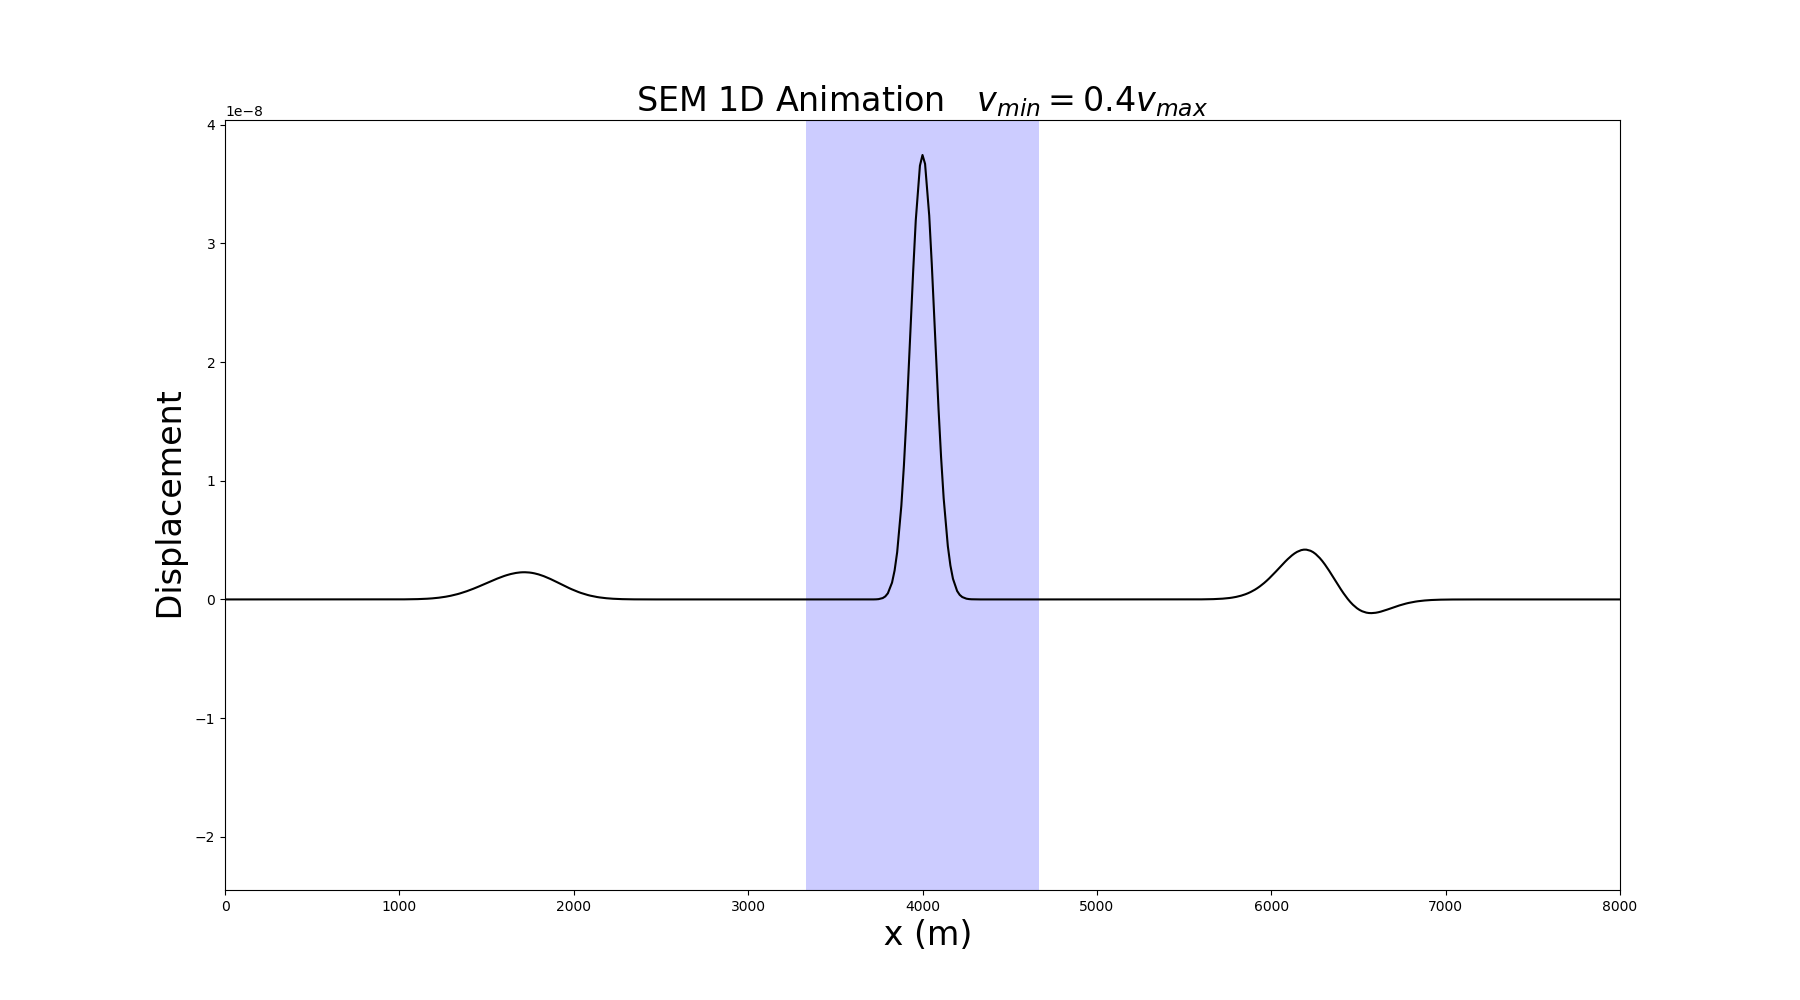

In [7]:
# SE Solution, Time extrapolation
# ---------------------------------------------------------------

# initialize source time function and force vector f
src  = ricker(dt,Tdom)
isrc = int(np.floor(ng/2))   # Source location

# Initialization of solution vectors
u = np.zeros(ng)
uold = u
unew = u
f = u 

# To avoid testing (with py.test nbval ...) the plotting section 
# NBVAL_IGNORE_OUTPUT
# --------------------------------------------------------------
# Initialize animated plot
# --------------------------------------------------------------  
#plt.figure(figsize=(10,6))
plt.figure(figsize=(18,10))

# ploting low velocity zone
half = np.floor(xmax/2)
plt.axvspan(half - el_span/2*le, 
            half + el_span/2*le,
            alpha=0.2, facecolor='b')
plt.title('SEM 1D Animation')
plt.xlabel(' x (m)')
plt.ylabel(' Amplitude ')
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 20,
        }

lines = plt.plot(xg, u, lw=1.5)
plt.title('SEM 1D Animation   $v_{min} = %s v_{max}$' %percent, size=24)
plt.xlabel(' x (m)', size=24)
plt.ylabel(' Displacement ', size=24)

plt.ion() # set interective mode
plt.show()

# ---------------------------------------------------------------
# Time extrapolation
# ---------------------------------------------------------------
x_t = []
for it in range(nt): 
    # Source initialization
    f = np.zeros(ng)
    if it < len(src):
        f[isrc-1] = src[it-1] 
               
    # Time extrapolation
    unew = dt**2 * Minv @ (f - K @ u) + 2 * u - uold
    uold, u = u, unew
    
    # Solution in space-time 
    x_t.append(u)

    # --------------------------------------   
    # Animation plot. Display solution 
    if not it % iplot:
        for l in lines:
            l.remove()
            del l
        # -------------------------------------- 
        # Display lines            
        lines = plt.plot(xg, u, color="black", lw = 1.5)
        plt.xlim((0,xmax))
        
        plt.gcf().canvas.draw()       

### 6. Displaying the wave-field 

<IPython.core.display.Javascript object>


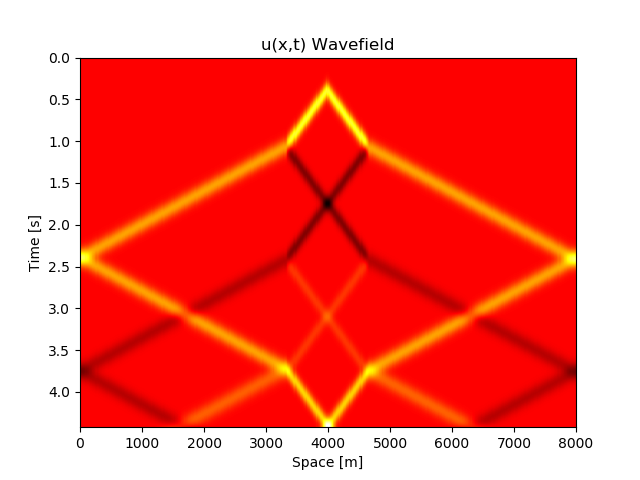

In [8]:
# Solution in space-time
x_t = np.asanyarray(x_t)

# To avoid testing (with py.test nbval ...) the plotting section 
# NBVAL_IGNORE_OUTPUT
# -------------------
# Initialize plot
plt.figure()
plt.subplot(1,1,1)
plt.imshow(x_t, cmap='hot', aspect='auto', 
          extent =[0, xmax,  nt*dt, 0])
plt.title('u(x,t) Wavefield')
plt.ylabel('Time [s]')
plt.xlabel('Space [m]')
plt.show()